# GTHA housing market database
# OSEMN methodology Step 3: Explore
# Exploratory Data Analysis (EDA) of the Teranet dataset
---

This notebook describes _Step 3: Explore_  of OSEMN methodology performed on the Teranet dataset.

Previous steps included: 

**Step 2: Scrub:**

* **Step 2.1:** spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

    * for details, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`

* **Step 2.2:** correction for consistency of the Teranet records

    * column names were converted to lower case
    
    * inconsistent capitalizations were fixed for columns
    
        * `municipality`    
        * `street_name`
        * `street_designation`
        * `postal_code` (did not show problems, converted as a preventive measure)
        
    * columns `province` and `street_suffix` were removed from the dataset
    
    * new column `street_name_raw` was created: reserve copy of unmodified `street_name`
    
    * column `street_name` was parsed and cleaned for:
    
        * `postal_code`
        * `unitno`
        * `street_number`
        * `street_direction`
        * `street_designation`
        
    * plots of the count and percentage of missing values per column were produced
    
    * inconsistent entries were fixed in the following columns:
        
        * `street_direction`
        * `street_designation`
        * `municipality`
        * `street_name`
        * `unitno`
        
    * for details, see `notebooks/2.scrub/2.2_teranet_consistency.ipynb`

* **Step 2.3:** addition of new attributes to the Teranet dataset

* during Step 2.3, **two versions of the Teranet dataset were produced**:

    * one where `consideration_amt` was left unmodified
    
    * one where `consideration_amt` < 10'000 CAD was reset to NaN and these records were removed from the dataset (1,615,178 records (23.74% of the total) have been removed. 5,188,513 records remain in the Teranet dataset).

New attributes were added to both versions of the Teranet dataset:
 
* surrogate key:

    * `transaction_id`: unique identifier for each Teranet transaction 
    
Essentially, a simple range index, which represents the row number of a record in the full Teranet dataset (filtered to include only GTHA records), ordered by date (from earliest to latest) and `pin`
    
* attributes for display

    * `date_disp`: `registration_date` converted to `datetime.date` data type to exclude the timestamp (original `registration_date` is stored in NumPy's `datetime64` format to allow more efficient datetime operations)
    
    * `price_disp`: `consideration_amt` formatted to include thousands separator (_e.g.,_ '3,455,122') and stored as a string, for display purposes
    
* attributes for record grouping
    
    * `year`: year parsed from `registration_date`, to simplify record grouping
    
    * `3year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2014-2016'), to simplify record grouping
    
    * `5year`: `registration_date` parsed for 5-year intervals (_e.g.,_ '2012-2016'), to simplify record grouping
    
    * `10year`: `registration_date` parsed for 3-year intervals (_e.g.,_ '2007-2017'), to simplify record grouping
    
    * `xy`: `x` and `y` coordinates concatenated together (_e.g.,_ '43.098324_-79.234235'), can be used to identify and group records by their coordinate pairs
    
* correction of `consideration_amt` for inflation    
    
    * `price_infl`: `consideration_amt` corrected for inflation
    
* exploratory attributes

    * `pin/xy_total_sales`: total records for this `pin`/`xy`

    * `pin/xy_prev_sales`: previous records from this `pin`/`xy` (not counting current transaction)

    * `pin/xy_price_cum_sum`: cumulative price of all records to date from this `pin`/`xy`

    * `pin/xy_price_pct_change`: price percentage change compared to previous record from this `pin`/`xy`

    * `price_da_pct_change`: price percentage change compared to previous record from this DA (by `da_id`)

    * `pin/xy_years_since_last_sale`: years since last sale from this `pin`/`xy`

    * `da_days_since_last_sale`, `da_years_since_last_sale`: days or years since last sale from this DA (by `da_id`)

    * `sale_next_6m/1y/3y`: "looks into the future" to see whether there is another transaction from this `pin`/`xy` within the given time horizon (6 months, 1 year, 3 years)

    * for details, see `notebooks/2.scrub/2.3_teranet_new_cols.ipynb` and `notebooks/2.scrub/2.3_teranet_nonan_new_cols.ipynb`

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 3: Explore_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import os
from time import time

pd.set_option('display.max_columns', 500)

sns.set()

In [2]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['3_Teranet_new_cols.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 'epoi_gtha13',
 '2_Teranet_consistent.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [3]:
from src.plot_utils import plot_count_mean_median

ModuleNotFoundError: No module named 'src'

## Load Teranet data

In [3]:
t = time()

df = pd.read_csv(data_path + '3_Teranet_nonan_new_cols.csv',
                 parse_dates=['registration_date'], low_memory=False, index_col='registration_date')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 82.37 seconds (1.37 minutes)
with 5,188,523 rows
and 54 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt', 'postal_code',
       'unitno', 'street_name', 'street_designation', 'street_direction',
       'municipality', 'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname',
       'taz_o', 'fsa', 'pca_id', 'postal_code_dmti', 'maf_id', 'del_m_id',
       'pin_lu', 'landuse', 'prop_code', 'street_name_raw', 'date_disp',
       'price_disp', 'year', 'year_month', 'year3', 'year5', 'year10', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_price_cum_sum', 'xy_price_cum_sum', 'pin_price_pct_change',
       'xy_price_pct_change', 'price_da_pct_change',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_next_6m', 'xy_sale_ne

In [9]:
df['del_m_id'].str.len().max()

6.0

In [14]:
df.query('municipality == "Hamilton"')[['landuse', 'prop_code']]

,landuse,prop_code
registration_date,,
1995-11-09,1.0,NaN
2010-03-30,1.0,NaN
2015-10-16,1.0,NaN
2017-03-30,1.0,NaN
2012-11-02,NaN,NaN
2017-07-26,NaN,NaN
2016-05-04,NaN,NaN
2003-01-15,1.0,NaN
2003-10-21,1.0,NaN


In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5188523 entries, 2012-03-29 to 2014-05-30
Data columns (total 54 columns):
transaction_id               5188523 non-null int64
lro_num                      5188523 non-null int64
pin                          5188523 non-null int64
consideration_amt            5188523 non-null float64
postal_code                  4881922 non-null object
unitno                       1332616 non-null object
street_name                  5144069 non-null object
street_designation           5090461 non-null object
street_direction             550657 non-null object
municipality                 5187171 non-null object
street_number                5142798 non-null object
x                            5188523 non-null float64
y                            5188523 non-null float64
dauid                        5188523 non-null int64
csduid                       5188523 non-null int64
csdname                      5188523 non-null object
taz_o                      

In [8]:
t = time()

df0 = pd.read_csv(data_path + '3_Teranet_new_cols.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df0.shape[0], df0.shape[1]) + 
      "\n-- Column names:\n", df0.columns)

----- DataFrame loaded
in 91.42 seconds (1.52 minutes)
with 6,803,756 rows
and 47 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o',
       'street_name_raw', 'date_disp', 'price_disp', 'year', 'year_month',
       'year3', 'year5', 'year10', 'xy', 'pin_total_sales', 'xy_total_sales',
       'pin_prev_sales', 'xy_prev_sales', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'da_days_since_last_sale',
       'da_years_since_last_sale', 'pin_sale_next_6m', 'pin_sale_next_1y',
       'pin_sale_next_3y', 'xy_sale_next_6m', 'xy_sale_next_1y',
       'xy_sale_next_3y', 'price_2016'],
      dtype='object')


In [6]:
df0.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6803691 entries, 0 to 6803690
Data columns (total 45 columns):
transaction_id               6803691 non-null int64
lro_num                      6803691 non-null int64
pin                          6803691 non-null int64
consideration_amt            6803691 non-null float64
registration_date            6803691 non-null datetime64[ns]
postal_code                  6233365 non-null object
unitno                       1572959 non-null object
street_name                  6598317 non-null object
street_designation           6522418 non-null object
street_direction             683462 non-null object
municipality                 6799681 non-null object
street_number                6594324 non-null object
x                            6803691 non-null float64
y                            6803691 non-null float64
objectid                     6803691 non-null int64
dauid                        6803691 non-null int64
csdname                      68036

## Count of records by Land Registry Office

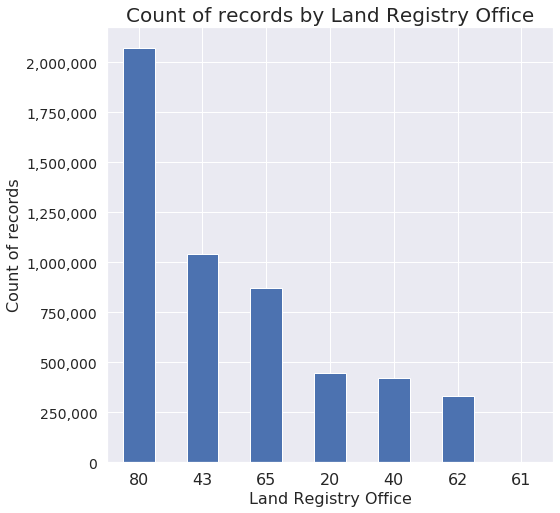

In [19]:
ax = df['lro_num'].value_counts().plot(kind='bar', figsize=(8, 8))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Land Registry Office", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Count of records by Land Registry Office", fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('results/plots/teranet_lro_count.png', dpi=300, bbox_inches='tight')

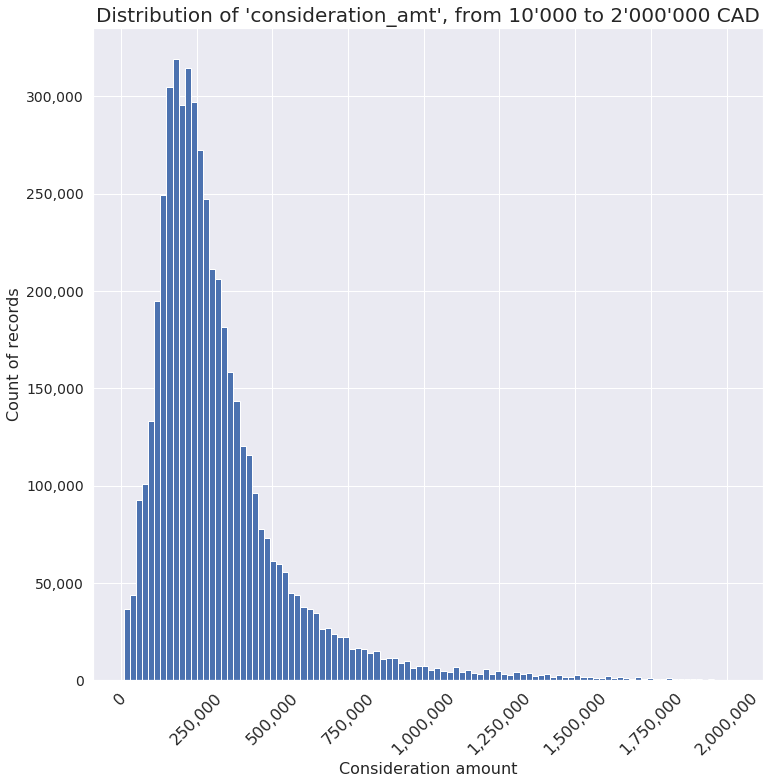

In [12]:
ax = df.query('price_2016 < 2000000')['consideration_amt']\
    .hist(bins=100, figsize=(12,12))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Consideration amount", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Distribution of 'consideration_amt', from 10'000 to 2'000'000 CAD", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('results/plots/teranet_price_dist.png', dpi=300, bbox_inches='tight')

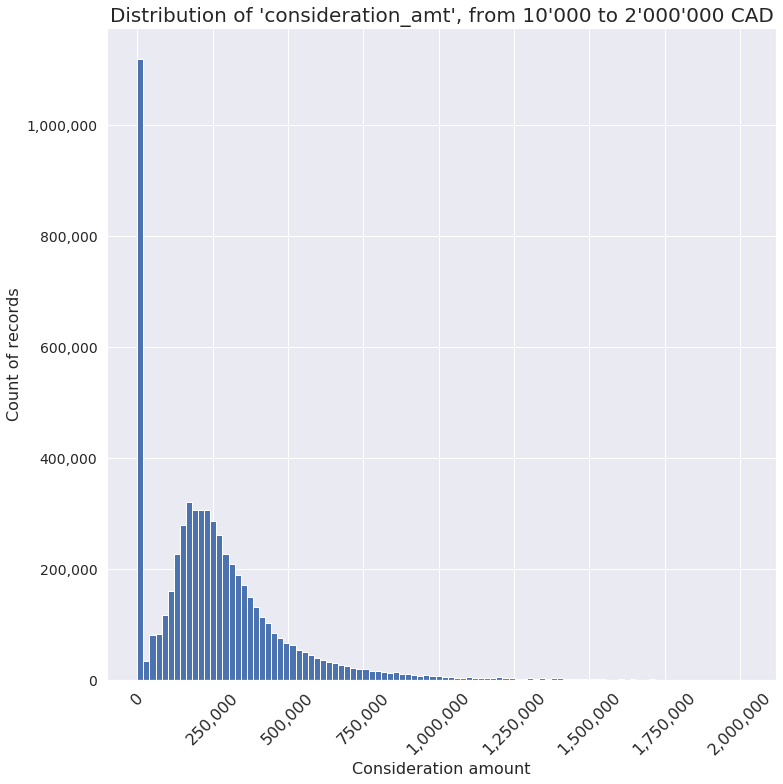

In [13]:
ax = df0.query('price_2016 < 2000000')['consideration_amt']\
    .hist(bins=100, figsize=(12,12))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Consideration amount", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Distribution of 'consideration_amt', from 10'000 to 2'000'000 CAD", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('results/plots/teranet_price_dist.png', dpi=300, bbox_inches='tight')

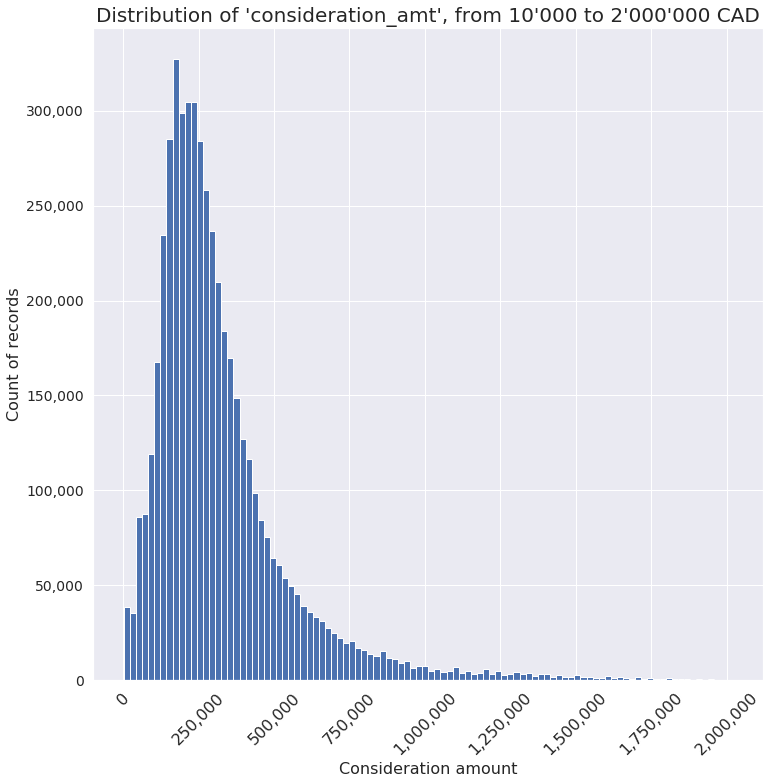

In [14]:
ax = df0.query('price_2016 < 2000000 & price_2016 > 5000')['consideration_amt']\
    .hist(bins=100, figsize=(12,12))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Consideration amount", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Distribution of 'consideration_amt', from 10'000 to 2'000'000 CAD", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('results/plots/teranet_price_dist.png', dpi=300, bbox_inches='tight')

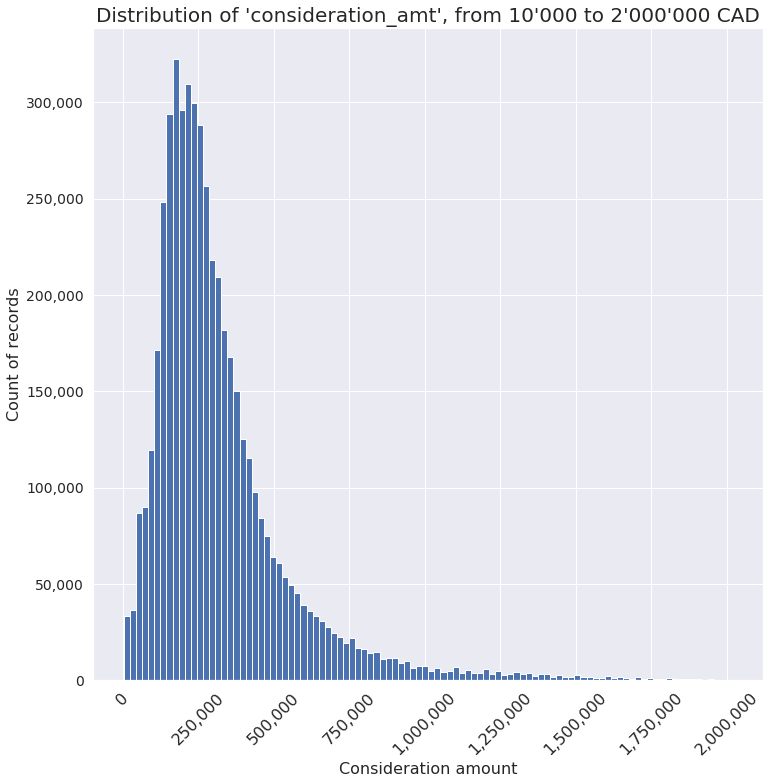

In [15]:
ax = df0.query('price_2016 < 2000000 & price_2016 > 8000')['consideration_amt']\
    .hist(bins=100, figsize=(12,12))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Consideration amount", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Distribution of 'consideration_amt', from 10'000 to 2'000'000 CAD", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('results/plots/teranet_price_dist.png', dpi=300, bbox_inches='tight')

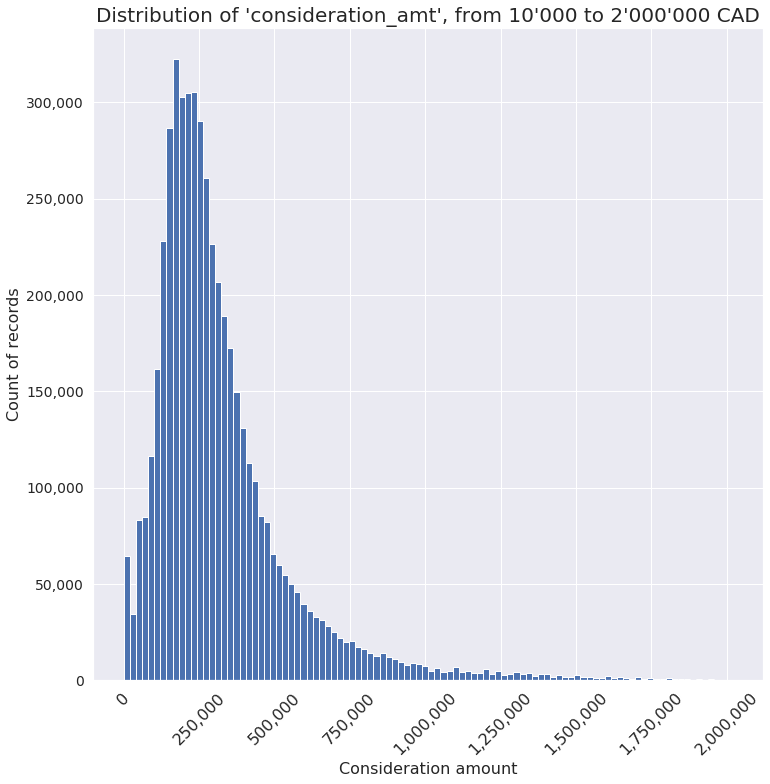

In [16]:
ax = df0.query('price_2016 < 2000000 & price_2016 > 1000')['consideration_amt']\
    .hist(bins=100, figsize=(12,12))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Consideration amount", fontsize=16)
ax.set_ylabel("Count of records", fontsize=16)
ax.set_title("Distribution of 'consideration_amt', from 10'000 to 2'000'000 CAD", fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
plt.savefig('results/plots/teranet_price_dist.png', dpi=300, bbox_inches='tight')

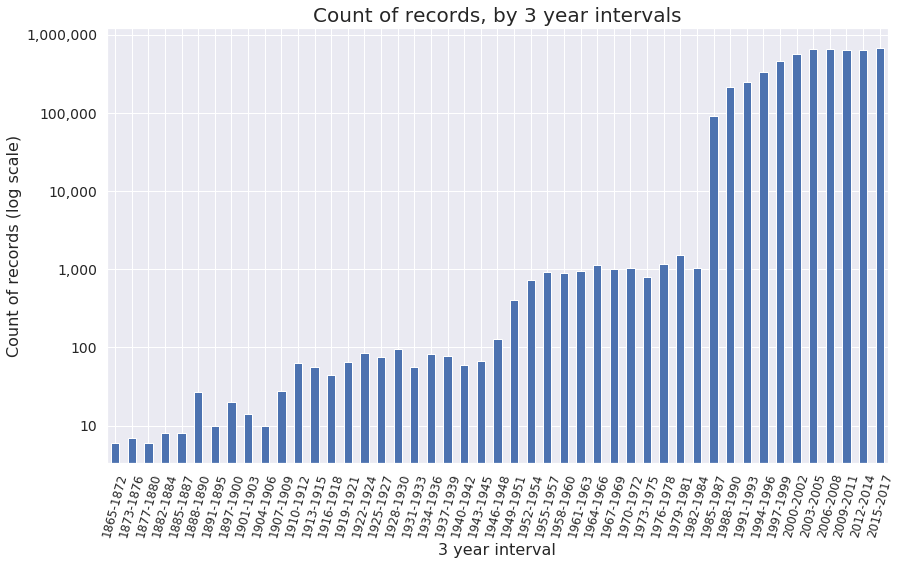

In [27]:
ax = df.groupby('year3')['consideration_amt'].count().plot(kind='bar', figsize=(14, 8))
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("3 year interval", fontsize=16)
ax.set_ylabel("Count of records (log scale)", fontsize=16)
ax.set_title("Count of records, by 3 year intervals", fontsize=20)
plt.xticks(rotation=75, fontsize=12)
plt.yticks(fontsize=14)
plt.savefig('results/plots/teranet_count_3year.png', dpi=300, bbox_inches='tight')

## Consideration amount corrected for inflation to 2016 prices

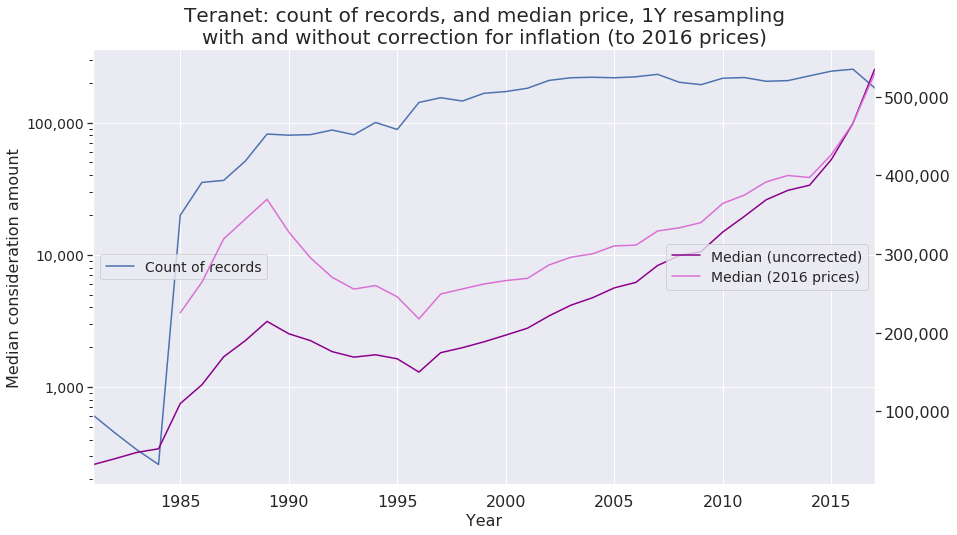

In [38]:
resample = '1Y'
min_year = 1980

ax = df.query('year > {0}'.format(min_year))['consideration_amt']\
    .resample(resample).count().plot(figsize=(14, 8), label='Count of records')

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Count of records (log scale)", fontsize=16)
ax.set_title("Teranet: count of records, and median price, {0} resampling".format(resample) + 
             "\nwith and without correction for inflation (to 2016 prices)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

ax2 = ax.twinx()
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
df.query('year > {0}'.format(min_year))['consideration_amt']\
    .resample(resample).median().plot(ax=ax2, color='darkmagenta', label='Median (uncorrected)')
df.query('year > {0}'.format(min_year))['price_infl']\
    .resample(resample).median().plot(ax=ax2, color='orchid', label='Median (2016 prices)')
ax.set_ylabel("Median consideration amount", fontsize=16)
ax2.grid(False)

ax.legend(loc='center left', fontsize=14)
ax2.legend(loc='center right', fontsize=14)
plt.savefig('results/plots/teranet_count_price_infl.png', dpi=300, bbox_inches='tight')

## Bamburgh Cir, Scarborough

In [51]:
mask1 = df['street_name'] == 'Bamburgh'
s = df[mask1]
s['street_number'].value_counts()

175.0    2908
55.0     2265
75.0     2048
25.0     1951
275.0    1552
225.0    1320
255.0    1286
125.0       3
390.0       3
375.0       2
20.0        2
100.0       1
Name: street_number, dtype: int64

In [52]:
print("{0:,} unique 'xy' in the subset.".format(s['xy'].nunique()))
s['xy'].value_counts()

12 unique 'xy' in the subset.


-79.32496909705041_43.81213550592261     2908
-79.3264117536627_43.814537555916786     2297
-79.3252294528648_43.81425816162989      2038
-79.3259198566481_43.8155083957929       1929
-79.3229961160854_43.8137662086411       1604
-79.3222035179342_43.813449502902785     1286
-79.32251755938421_43.8124753823435      1268
-79.32344909155809_43.816870939800786       3
-79.325576564195_43.813267517471            3
-79.3249454612838_43.816417450836894        2
-79.3233179942909_43.81534541985809         2
-79.3283686395606_43.813932882027395        1
Name: xy, dtype: int64

In [53]:
print("{0:,} unique pin".format(s['pin'].nunique()))
s['pin'].value_counts()

4,850 unique pin


117630346    9
117630345    9
117990049    9
117630093    9
117990694    9
117630647    8
116840548    8
117260027    8
117990067    8
117990795    8
117630183    8
117990944    8
117260331    8
117990170    8
117990776    8
116840355    7
117670156    7
117630367    7
117670067    7
117410216    7
117990196    7
117990062    7
117990355    7
117260092    7
116840156    7
116840640    7
116840282    7
116840267    7
116840279    7
117260094    7
            ..
117410331    1
117670434    1
117410339    1
117410347    1
117670371    1
117670450    1
117260698    1
117260690    1
117630275    1
117410187    1
117990210    1
117410623    1
117410059    1
117260562    1
117410615    1
117410083    1
117410607    1
117990178    1
117260602    1
117410107    1
117410123    1
117410575    1
117410131    1
117260634    1
117410485    1
117670316    1
117410155    1
117260666    1
117260674    1
117670092    1
Name: pin, Length: 4850, dtype: int64

In [57]:
def plot_count_mean_median(s, group_col, plot_col, figsize=(8, 8), tick_label_size=16,
                           ax1_leg_label='count', ax2_leg_label1='median', ax2_leg_label2='mean',
                           cust_xticks=False, xticks_rot=45, x_ticks_lab_size=16,
                           ax1_color='darkblue', ax2_color1='mediumspringgreen', ax2_color2='deeppink',
                           ax1_yticks_sep=True, ax2_yticks_sep=True,
                           ax1_ylabel="count", ax1_xlabel="x", ax2_ylabel="mean and median",
                           ylabel_size=16, xlabel_size=16,
                           plot_title="Count, mean, and median", title_size=20,
                           ax1_leg_loc='upper left', ax2_legend_loc='center right',
                           ax1_leg_size=16, ax2_leg_size=16,
                           save_path=None, save_dpi=300):
    """
    plot count, mean, and median from groups by group_col of values in plot_col
    :param s: pandas DataFrame
        subset to plot
    :param group_col: string
        name of column to group subset by
    :param plot_col: string
        name of column to plot
    :param figsize: (int or float, int or float)
        tuple with figure dimensions
    :param tick_label_size: int
        font size for tick labels
    :param ax1_leg_label: string
        legend label for left y axis
    :param ax2_leg_label1: string
        legend label for line 1 on right y axis
    :param ax2_leg_label2: string
        legend label for line 2 on right y axis
    :param cust_xticks: boolean
        whether to use x ticks with rotation and custom font size
    :param xticks_rot: int
        rotation (degrees) for custom x ticks
    :param x_ticks_lab_size: int
        font size for custom x ticks
    :param ax1_color: string
        line color on left y axis
    :param ax2_color1: string
        line 1 color on right y axis
    :param ax2_color2: string
        line 2 color on right y axis
    :param ax1_yticks_sep: boolean
        format y ticks on left y axis to include thousands separator (e.g., 1'045'543)
    :param ax2_yticks_sep: boolean
        format y ticks on right y axis to include thousands separator (e.g., 1'045'543)
    :param ax1_ylabel: string
        label for left y axis
    :param ax1_xlabel: string
        label for x axis
    :param ax2_ylabel: string
        label for right y axis
    :param ylabel_size: int
        y label size
    :param xlabel_size: int
        x label size
    :param plot_title: string
        title of the plot
    :param title_size: int
        font size for plot title
    :param ax1_leg_loc: string
        location of legend for left y axis
    :param ax2_legend_loc: string
        location of legend for right y axis
    :param ax1_leg_size: int
        size of legend font for left y axis
    :param ax2_leg_size: int
        size of legend font for right y axis
    :param save_path: string
        path to save figure (default=None results in plt.show)
    :param save_dpi: int
        DPI to use for saved figure
    :return: None
        plots and optionally saves the figure to file
    """
    plt.rcParams['xtick.labelsize'] = tick_label_size
    plt.rcParams['ytick.labelsize'] = tick_label_size

    ax = s.groupby(group_col)[plot_col].count().plot(figsize=figsize, label=ax1_leg_label, color=ax1_color)
    if cust_xticks:
        plt.xticks(rotation=xticks_rot, fontsize=x_ticks_lab_size)
    ax2 = ax.twinx()
    s.groupby(group_col)[plot_col].median().plot(ax=ax2, color=ax2_color1, label=ax2_leg_label1)
    s.groupby(group_col)[plot_col].mean().plot(ax=ax2, color=ax2_color2, label=ax2_leg_label2)

    if ax1_yticks_sep:
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if ax2_yticks_sep:
        ax2.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.grid(False)
    ax.set_ylabel(ax1_ylabel, fontsize=ylabel_size)
    ax.set_xlabel(ax1_xlabel, fontsize=xlabel_size)
    ax2.set_ylabel(ax2_ylabel, fontsize=ylabel_size)
    ax2.set_title(plot_title, fontsize=title_size)
    ax.legend(loc=ax1_leg_loc, fontsize=ax1_leg_size)
    ax2.legend(loc=ax2_legend_loc, fontsize=ax2_leg_size)
    if save_path:
        plt.savefig(save_path, dpi=save_dpi, bbox_inches='tight')
    else:
        plt.show()


In [ ]:
group_col = 'year'
plot_col = 'price_infl'
ax1_ylabel = 'Count of records'
ax1_xlabel = 'Year'
ax2_ylabel = 'Mean and median price'
plot_title = 'Teranet: Bamburgh Cir, Scarborough\nrecord count, mean and median price\ngrouped by year'

plot_count_mean_median(s, group_col, plot_col, 
                       ax1_ylabel=ax1_ylabel, ax1_xlabel=ax1_xlabel, ax2_ylabel=ax2_ylabel, plot_title=plot_title)

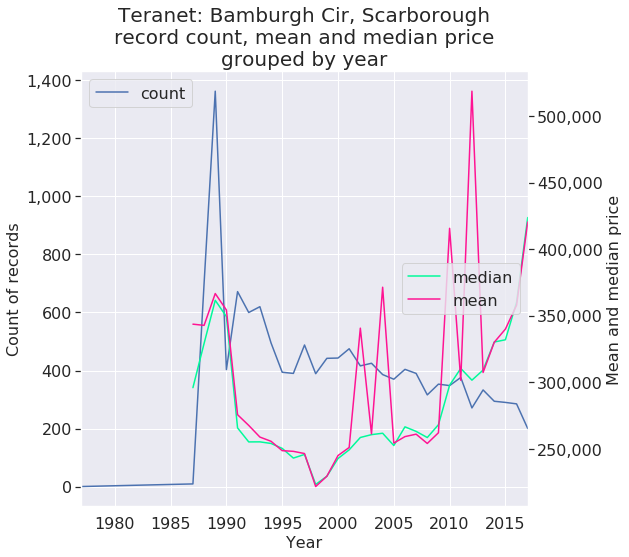

In [48]:
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

plot_col = 'price_infl'
group_col = 'year'

ax = s.groupby(group_col)[plot_col].count().plot(figsize=(8, 8), label='count')
# plt.xticks(rotation=45, fontsize=16)
ax2 = ax.twinx()
s.groupby(group_col)[plot_col].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby(group_col)[plot_col].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: Bamburgh Cir, Scarborough\nrecord count, mean and median price'
              '\ngrouped by year', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()

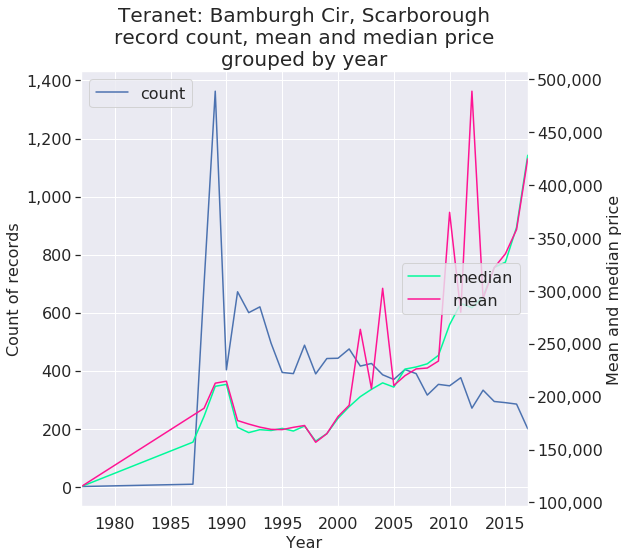

In [11]:
plot_col = 'price_infl'
group_col = 'year'

ax = s.groupby(group_col)[plot_col].count().plot(figsize=(8, 8), label='count')
# plt.xticks(rotation=45, fontsize=16)
ax2 = ax.twinx()
s.groupby(col)['consideration_amt'].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby(col)['consideration_amt'].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: Bamburgh Cir, Scarborough\nrecord count, mean and median price'
              '\ngrouped by year', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()

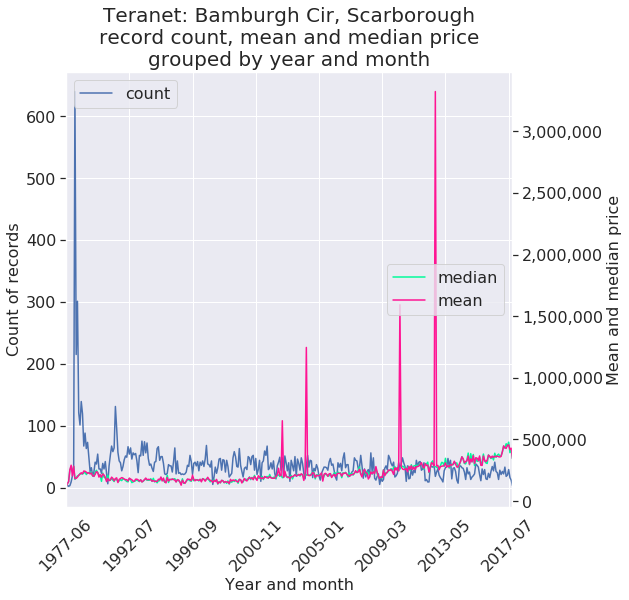

In [68]:
col = 'year_month'
ax = s.groupby(col)['consideration_amt'].count().plot(figsize=(8, 8), label='count')
plt.xticks(rotation=45, fontsize=16)
ax2 = ax.twinx()
s.groupby(col)['consideration_amt'].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby(col)['consideration_amt'].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year and month', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: Bamburgh Cir, Scarborough\nrecord count, mean and median price'
              '\ngrouped by year and month', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()

### Sales of the same unit

In [15]:
display_cols = ['pin', 'unitno', 'street_number', 'street_name', 'street_designation', 
                'municipality', 'price_disp', 'pin_price_pct_change', 'date_disp', 
                'pin_prev_sales', 'pin_years_since_last_sale', 'xy_prev_sales', 'y', 'x']

#### Unit 726 of 75 Bamburgh Cir, Scarborough

In [16]:
mask2 = df['pin'] == 117630346
df.loc[mask1 & mask2, display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
1071924,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"210,000.0",NaN,1991-08-26,0,NaN,445,43.814258,-79.325229
1072279,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"187,500.0",-0.107143,1994-08-29,1,3.010959,800,43.814258,-79.325229
1072491,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"186,000.0",-0.008000,1998-11-16,2,4.219178,1012,43.814258,-79.325229
1072976,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"245,000.0",0.317204,2006-09-25,3,7.863014,1497,43.814258,-79.325229
1073185,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"155,800.0",-0.364082,2010-07-06,4,3.780822,1706,43.814258,-79.325229
1073213,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"318,000.0",1.041078,2011-02-08,5,0.594521,1735,43.814258,-79.325229
1073234,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"320,000.0",0.006289,2011-08-11,6,0.504110,1755,43.814258,-79.325229
1073392,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"385,000.0",0.203125,2015-01-29,7,3.471233,1913,43.814258,-79.325229
1073498,117630346,726.0,75.0,Bamburgh,Cir,Scarborough,"480,000.0",0.246753,2017-05-17,8,2.298630,2019,43.814258,-79.325229


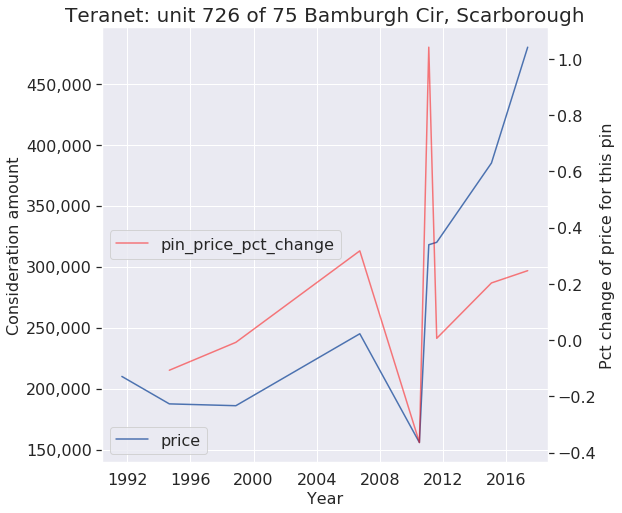

In [17]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'consideration_amt'], label='price')
ax2 = ax.twinx()
ax2.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'pin_price_pct_change'], color='red', alpha=0.5,
         label='pin_price_pct_change')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Consideration amount', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Pct change of price for this pin', fontsize=16)
ax2.set_title('Teranet: unit 726 of 75 Bamburgh Cir, Scarborough', fontsize=20)
ax.legend(loc='lower left', fontsize=16)
ax2.legend(loc='center left', fontsize=16)
plt.show()

#### Unit 1518 of 75 Bamburgh Cir, Scarborough

In [18]:
mask2 = df['pin'] == 117630647
df.loc[mask1 & mask2, display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
1071632,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"228,000.0",NaN,1989-03-01,0,NaN,153,43.814258,-79.325229
1072514,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"165,000.0",-0.276316,1999-05-19,1,10.221918,1035,43.814258,-79.325229
1072675,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"210,500.0",0.275758,2001-10-16,2,2.413699,1196,43.814258,-79.325229
1072816,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"240,000.0",0.140143,2003-10-06,3,1.972603,1337,43.814258,-79.325229
1072979,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"246,000.0",0.025000,2006-09-29,4,2.983562,1500,43.814258,-79.325229
1073023,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"250,000.0",0.016260,2007-07-27,5,0.824658,1544,43.814258,-79.325229
1073322,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"325,000.0",0.300000,2013-06-13,6,5.884932,1843,43.814258,-79.325229
1073434,117630647,1518.0,75.0,Bamburgh,Cir,Scarborough,"430,000.0",0.323077,2016-05-31,7,2.967123,1955,43.814258,-79.325229


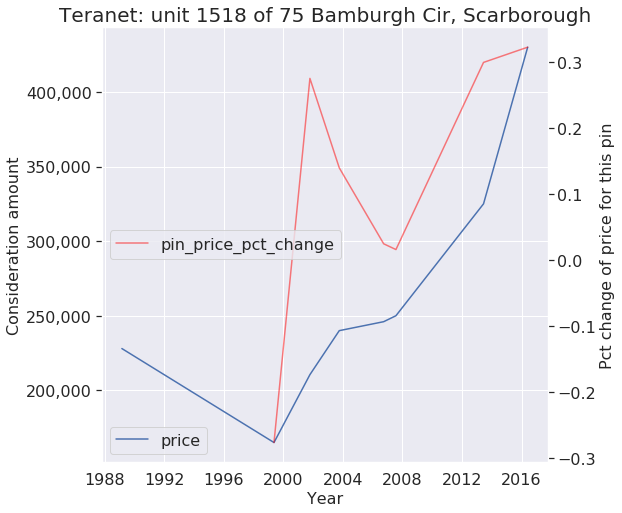

In [19]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'consideration_amt'], label='price')
ax2 = ax.twinx()
ax2.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'pin_price_pct_change'], color='red', alpha=0.5,
         label='pin_price_pct_change')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Consideration amount', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Pct change of price for this pin', fontsize=16)
ax2.set_title('Teranet: unit 1518 of 75 Bamburgh Cir, Scarborough', fontsize=20)
ax.legend(loc='lower left', fontsize=16)
ax2.legend(loc='center left', fontsize=16)
plt.show()

#### Unit 406 of 175 Bamburgh Cir, Scarborough

In [20]:
mask2 = df['pin'] == 117990049
df.loc[mask1 & mask2, display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
1064769,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"93,700.0",NaN,1988-12-07,0,NaN,34,43.812136,-79.324969
1065707,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"143,000.0",0.526147,1990-12-14,1,2.019178,972,43.812136,-79.324969
1065920,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"130,000.0",-0.090909,1992-10-29,2,1.876712,1185,43.812136,-79.324969
1066181,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"123,500.0",-0.050000,1995-11-21,3,3.063014,1446,43.812136,-79.324969
1066463,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"132,000.0",0.068826,1998-12-03,4,3.035616,1728,43.812136,-79.324969
1066688,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"151,000.0",0.143939,2001-07-10,5,2.602740,1953,43.812136,-79.324969
1066792,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"174,000.0",0.152318,2002-08-30,6,1.139726,2057,43.812136,-79.324969
1067012,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"97,850.0",-0.437644,2005-04-12,7,2.619178,2277,43.812136,-79.324969
1067486,117990049,406.0,175.0,Bamburgh,Cir,Scarborough,"246,500.0",1.519162,2013-08-22,8,8.367123,2751,43.812136,-79.324969


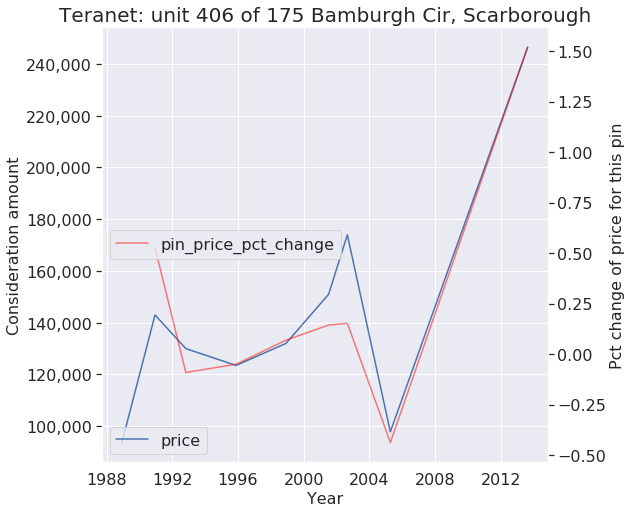

In [21]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'consideration_amt'], label='price')
ax2 = ax.twinx()
ax2.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'pin_price_pct_change'], color='red', alpha=0.5,
         label='pin_price_pct_change')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Consideration amount', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Pct change of price for this pin', fontsize=16)
ax2.set_title('Teranet: unit 406 of 175 Bamburgh Cir, Scarborough', fontsize=20)
ax.legend(loc='lower left', fontsize=16)
ax2.legend(loc='center left', fontsize=16)
plt.show()

#### Unit 610 of 55 Bamburgh Cir, Scarborough

In [22]:
mask2 = df['pin'] == 116840548
df.loc[mask1 & mask2, display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
1085394,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"196,980.0",NaN,1989-01-16,0,NaN,130,43.814538,-79.326412
1085712,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"164,500.0",-0.164890,1991-09-18,1,2.671233,448,43.814538,-79.326412
1086185,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"160,000.0",-0.027356,1996-11-29,2,5.202740,920,43.814538,-79.326412
1086577,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"188,888.0",0.180550,2001-07-31,3,4.671233,1313,43.814538,-79.326412
1086687,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"198,000.0",0.048240,2002-12-20,4,1.389041,1423,43.814538,-79.326412
1086841,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"206,000.0",0.040404,2005-10-21,5,2.838356,1577,43.814538,-79.326412
1087260,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"293,000.0",0.422330,2012-06-28,6,6.690411,1996,43.814538,-79.326412
1087495,116840548,610.0,55.0,Bamburgh,Cir,Scarborough,"376,000.0",0.283276,2016-09-15,7,4.219178,2231,43.814538,-79.326412


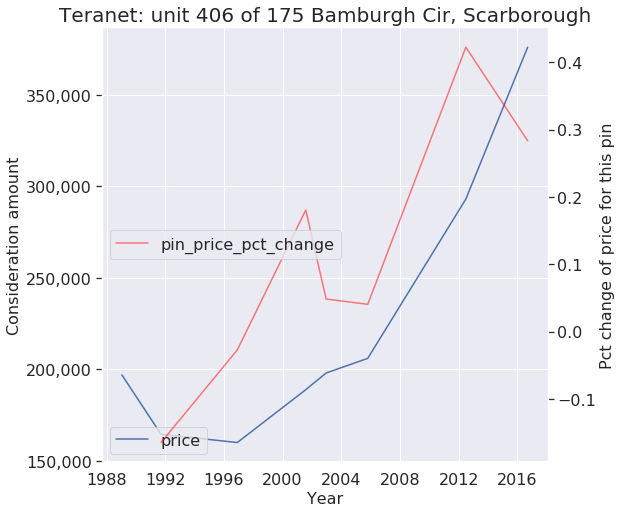

In [23]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'consideration_amt'], label='price')
ax2 = ax.twinx()
ax2.plot(s.loc[mask2, 'registration_date'], s.loc[mask2, 'pin_price_pct_change'], color='red', alpha=0.5,
         label='pin_price_pct_change')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Consideration amount', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Pct change of price for this pin', fontsize=16)
ax2.set_title('Teranet: unit 406 of 175 Bamburgh Cir, Scarborough', fontsize=20)
ax.legend(loc='lower left', fontsize=16)
ax2.legend(loc='center left', fontsize=16)
plt.show()

## East Liberty St, Toronto

In [70]:
mask1 = df['street_name'] == 'East Liberty'
s = df[mask1]
print("{0:,} unique street numbers".format(s['street_number'].nunique()))
s['street_number'].value_counts()

19 unique street numbers


150.0    1714
85.0     1671
65.0     1501
75.0     1386
59.0     1170
55.0     1122
51.0     1074
54.0      308
50.0      296
57.0       78
77.0       10
46.0       10
73.0        9
69.0        7
81.0        7
79.0        6
83.0        3
87.0        3
132.0       1
Name: street_number, dtype: int64

In [71]:
s['xy'].value_counts()

-79.4147397566295_43.6379922562        4603
-79.4132147962959_43.6385031485826     2370
-79.4160984117317_43.6387707571755     1714
-79.4118959508863_43.6386377731984     1074
-79.4132262547037_43.63955904045871     614
-79.4164905449281_43.63934308445128       1
Name: xy, dtype: int64

In [72]:
print("{0:,} unique pin".format(s['pin'].nunique()))
s['pin'].value_counts()

7,179 unique pin


126600267    6
126600314    6
126600023    6
126600001    5
126600254    5
126600338    5
126600096    5
126600288    5
761770452    5
126600022    5
126600281    5
126600326    5
126600242    5
126600355    5
126600278    5
126600353    5
126600075    5
126600296    5
126600074    5
761770267    5
127050142    5
126600114    5
761770090    4
761770035    4
126600111    4
761640701    4
126600290    4
127050152    4
761770566    4
126600325    4
            ..
763221672    1
761640745    1
763221470    1
763221478    1
763221486    1
764950002    1
763220053    1
764950010    1
761640370    1
763221422    1
761640488    1
763221406    1
763221342    1
761640290    1
763221350    1
761640306    1
763710837    1
763221366    1
763710845    1
761640322    1
763710853    1
763221382    1
761640330    1
761640338    1
763710869    1
763221398    1
761640570    1
761640346    1
763710877    1
763222019    1
Name: pin, Length: 7179, dtype: int64

In [33]:
s[display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
2072564,764950008,201.0,51.0,East Liberty,St,Toronto,"335,428.0",NaN,2016-01-18,0,NaN,0,43.638638,-79.411896
2072565,764950009,202.0,51.0,East Liberty,St,Toronto,"334,354.0",NaN,2016-01-18,0,NaN,1,43.638638,-79.411896
2072566,764950013,206.0,51.0,East Liberty,St,Toronto,"228,009.0",NaN,2016-01-18,0,NaN,2,43.638638,-79.411896
2072567,764950019,NaN,51.0,East Liberty,St,Toronto,"330,226.0",NaN,2016-01-18,0,NaN,3,43.638638,-79.411896
2072568,764950022,NaN,51.0,East Liberty,St,Toronto,"233,096.0",NaN,2016-01-18,0,NaN,4,43.638638,-79.411896
2072569,764950023,NaN,51.0,East Liberty,St,Toronto,"233,091.0",NaN,2016-01-18,0,NaN,5,43.638638,-79.411896
2072570,764950025,NaN,51.0,East Liberty,St,Toronto,"232,146.0",NaN,2016-01-18,0,NaN,6,43.638638,-79.411896
2072571,764950026,NaN,51.0,East Liberty,St,Toronto,"231,186.0",NaN,2016-01-18,0,NaN,7,43.638638,-79.411896
2072572,764950027,NaN,51.0,East Liberty,St,Toronto,"231,190.0",NaN,2016-01-18,0,NaN,8,43.638638,-79.411896
2072573,764950028,NaN,51.0,East Liberty,St,Toronto,"393,483.0",NaN,2016-01-18,0,NaN,9,43.638638,-79.411896


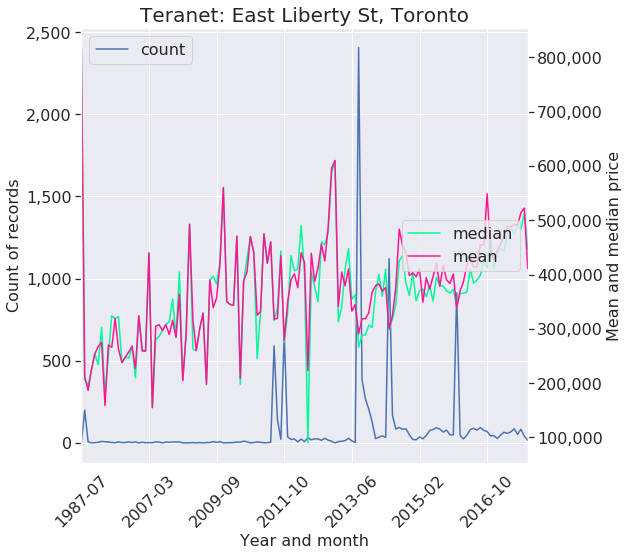

In [34]:
ax = s.groupby('year_month')['consideration_amt'].count().plot(figsize=(8, 8), label='count')
plt.xticks(rotation=45, fontsize=16)
ax2 = ax.twinx()
s.groupby('year_month')['consideration_amt'].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby('year_month')['consideration_amt'].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year and month', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: East Liberty St, Toronto', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()

## Absolute Ave, Mississauga

In [35]:
mask1 = df['street_name'] == 'Absolute'
s = df[mask1]
s['street_number'].value_counts()

50.0    2685
80.0    2354
90.0    2214
70.0    2206
60.0    1252
Name: street_number, dtype: int64

In [36]:
s['xy'].value_counts()

-79.6352846277786_43.5952539512044    10711
Name: xy, dtype: int64

In [37]:
s['pin'].value_counts()

198070857    7
198070388    7
198070773    7
198070873    5
198090040    5
198070670    5
198070029    5
198090028    5
198090078    5
198090579    5
198070061    5
198070576    5
198070210    5
198090872    5
198070837    5
198500899    5
198070813    5
198070560    5
198070875    5
198070789    5
198070186    5
198070442    5
198070349    5
198090006    5
198070209    5
198500094    5
198070760    5
198070430    5
198070736    5
198070704    5
            ..
199390748    1
199300632    1
199300839    1
199390740    1
199391027    1
198090249    1
199300616    1
199390724    1
199300608    1
198500386    1
199300879    1
199300680    1
198070028    1
198500157    1
199300847    1
199300728    1
199390836    1
199390963    1
198070004    1
198090486    1
199300855    1
199300712    1
199301033    1
199300863    1
198090329    1
199300871    1
199390987    1
198090321    1
198500501    1
198070270    1
Name: pin, Length: 5546, dtype: int64

In [38]:
s[display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
3521161,198070003,103.0,90.0,Absolute,Ave,Mississauga,"310,011.0",NaN,2007-05-23,0,NaN,0,43.595254,-79.635285
3521162,198070005,105.0,90.0,Absolute,Ave,Mississauga,"278,129.0",NaN,2007-05-23,0,NaN,1,43.595254,-79.635285
3521163,198070006,106.0,90.0,Absolute,Ave,Mississauga,"341,329.0",NaN,2007-05-23,0,NaN,2,43.595254,-79.635285
3521164,198070007,107.0,90.0,Absolute,Ave,Mississauga,"324,368.0",NaN,2007-05-23,0,NaN,3,43.595254,-79.635285
3521165,198070010,110.0,90.0,Absolute,Ave,Mississauga,"301,873.0",NaN,2007-05-23,0,NaN,4,43.595254,-79.635285
3521166,198070011,111.0,90.0,Absolute,Ave,Mississauga,"295,619.0",NaN,2007-05-23,0,NaN,5,43.595254,-79.635285
3521167,198070012,112.0,90.0,Absolute,Ave,Mississauga,"297,828.0",NaN,2007-05-23,0,NaN,6,43.595254,-79.635285
3521168,198070016,116.0,90.0,Absolute,Ave,Mississauga,"248,756.0",NaN,2007-05-23,0,NaN,7,43.595254,-79.635285
3521169,198070017,117.0,90.0,Absolute,Ave,Mississauga,"239,261.0",NaN,2007-05-23,0,NaN,8,43.595254,-79.635285
3521170,198070018,118.0,90.0,Absolute,Ave,Mississauga,"239,185.0",NaN,2007-05-23,0,NaN,9,43.595254,-79.635285


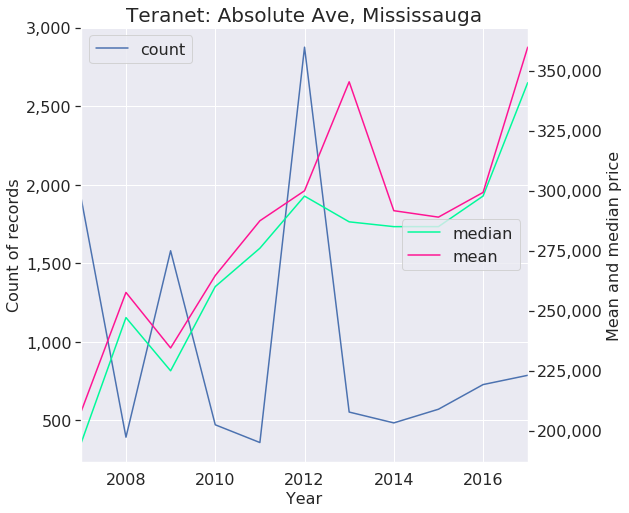

In [39]:
ax = s.groupby('year')['consideration_amt'].count().plot(figsize=(8, 8), label='count')
ax2 = ax.twinx()
s.groupby('year')['consideration_amt'].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby('year')['consideration_amt'].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: Absolute Ave, Mississauga', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()

## East Liberty St, Toronto

In [46]:
df['street_name'].value_counts()

Yonge                        68438
King                         40086
Bay                          31385
Sheppard                     30560
Lakeshore                    26908
Eglinton                     25383
Queens                       22624
Bloor                        20727
Lake Shore                   20023
Harrison Garden              19590
Bayview                      18106
Dundas                       17492
Front                        17325
Hillcrest                    16786
Queen                        16647
Lee Centre                   16373
Webb                         14741
Richmond                     13943
Burnhamthorpe                13726
Finch                        13677
Bamburgh                     13341
Kingsbridge Garden           13307
Lawrence                     13192
Fort York                    12720
Mill                         12662
Main                         12323
Bathurst                     12029
Elm                          11995
Steeles             

In [47]:
mask1 = df['street_name'] == 'Absolute'
s = df[mask1]
s['street_number'].value_counts()

50.0    2685
80.0    2354
90.0    2214
70.0    2206
60.0    1252
Name: street_number, dtype: int64

In [48]:
s['xy'].value_counts()

-79.6352846277786_43.5952539512044    10711
Name: xy, dtype: int64

In [49]:
s['pin'].value_counts()

198070857    7
198070388    7
198070773    7
198070873    5
198090040    5
198070670    5
198070029    5
198090028    5
198090078    5
198090579    5
198070061    5
198070576    5
198070210    5
198090872    5
198070837    5
198500899    5
198070813    5
198070560    5
198070875    5
198070789    5
198070186    5
198070442    5
198070349    5
198090006    5
198070209    5
198500094    5
198070760    5
198070430    5
198070736    5
198070704    5
            ..
199390748    1
199300632    1
199300839    1
199390740    1
199391027    1
198090249    1
199300616    1
199390724    1
199300608    1
198500386    1
199300879    1
199300680    1
198070028    1
198500157    1
199300847    1
199300728    1
199390836    1
199390963    1
198070004    1
198090486    1
199300855    1
199300712    1
199301033    1
199300863    1
198090329    1
199300871    1
199390987    1
198090321    1
198500501    1
198070270    1
Name: pin, Length: 5546, dtype: int64

In [50]:
s[display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
3521161,198070003,103.0,90.0,Absolute,Ave,Mississauga,"310,011.0",NaN,2007-05-23,0,NaN,0,43.595254,-79.635285
3521162,198070005,105.0,90.0,Absolute,Ave,Mississauga,"278,129.0",NaN,2007-05-23,0,NaN,1,43.595254,-79.635285
3521163,198070006,106.0,90.0,Absolute,Ave,Mississauga,"341,329.0",NaN,2007-05-23,0,NaN,2,43.595254,-79.635285
3521164,198070007,107.0,90.0,Absolute,Ave,Mississauga,"324,368.0",NaN,2007-05-23,0,NaN,3,43.595254,-79.635285
3521165,198070010,110.0,90.0,Absolute,Ave,Mississauga,"301,873.0",NaN,2007-05-23,0,NaN,4,43.595254,-79.635285
3521166,198070011,111.0,90.0,Absolute,Ave,Mississauga,"295,619.0",NaN,2007-05-23,0,NaN,5,43.595254,-79.635285
3521167,198070012,112.0,90.0,Absolute,Ave,Mississauga,"297,828.0",NaN,2007-05-23,0,NaN,6,43.595254,-79.635285
3521168,198070016,116.0,90.0,Absolute,Ave,Mississauga,"248,756.0",NaN,2007-05-23,0,NaN,7,43.595254,-79.635285
3521169,198070017,117.0,90.0,Absolute,Ave,Mississauga,"239,261.0",NaN,2007-05-23,0,NaN,8,43.595254,-79.635285
3521170,198070018,118.0,90.0,Absolute,Ave,Mississauga,"239,185.0",NaN,2007-05-23,0,NaN,9,43.595254,-79.635285


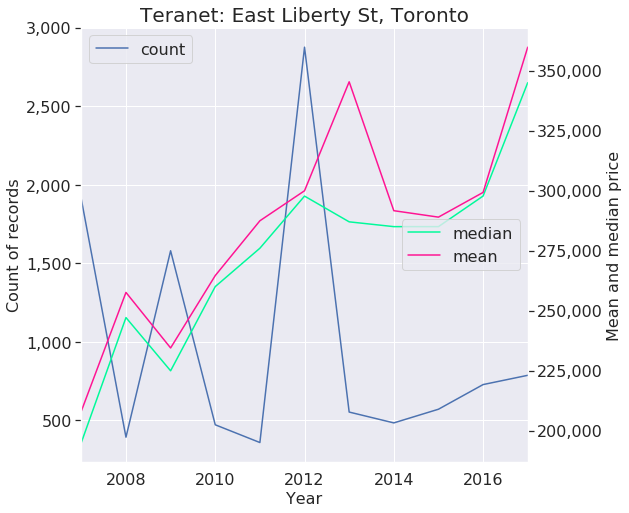

In [51]:
ax = s.groupby('year')['consideration_amt'].count().plot(figsize=(8, 8), label='count')
ax2 = ax.twinx()
s.groupby('year')['consideration_amt'].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby('year')['consideration_amt'].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: East Liberty St, Toronto', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()

## 300 Bloor St East

In [73]:
mask1 = df['street_name'] == 'Bloor'
df.loc[mask1, 'street_number'].value_counts()

300.0     1691
1333.0    1384
1369.0    1348
1830.0    1240
1.0       1221
85.0      1084
1300.0    1045
55.0       970
110.0      849
2855.0     836
102.0      750
3391.0     725
3085.0     581
2662.0     520
388.0      431
278.0      384
1615.0     327
1625.0     324
1624.0     312
1638.0     277
360.0      274
400.0      262
1660.0     259
284.0      241
2511.0     201
409.0      183
1646.0     163
421.0       94
206.0       91
2545.0      65
          ... 
2294.0       1
807          1
2891.0       1
3989.0       1
2252.0       1
606.0        1
926.0        1
1432.0       1
2553.0       1
3972.0       1
906.0        1
1187.0       1
696.0        1
1866.0       1
411.0        1
1934.0       1
3826.0       1
2651.0       1
1290.0       1
1582.0       1
282.0        1
3825.0       1
631.0        1
2320.0       1
152.0        1
2436.0       1
992.0        1
3326.0       1
2816.0       1
2288.0       1
Name: street_number, Length: 1170, dtype: int64

In [74]:
mask2 = df['street_number'] == '300.0'
s = df[mask1 & mask2]
s[display_cols]

,pin,unitno,street_number,street_name,street_designation,municipality,price_disp,pin_price_pct_change,date_disp,pin_prev_sales,pin_years_since_last_sale,xy_prev_sales,y,x
1469196,124830003,303.0,300.0,Bloor,St,Toronto,"195,138.0",NaN,2003-01-15,0,NaN,0,43.672362,-79.380009
1469197,124830004,304.0,300.0,Bloor,St,Toronto,"192,637.0",NaN,2003-01-15,0,NaN,1,43.672362,-79.380009
1469198,124830006,306.0,300.0,Bloor,St,Toronto,"222,403.0",NaN,2003-01-15,0,NaN,2,43.672362,-79.380009
1469199,124830010,310.0,300.0,Bloor,St,Toronto,"197,423.0",NaN,2003-01-15,0,NaN,3,43.672362,-79.380009
1469200,124830012,312.0,300.0,Bloor,St,Toronto,"230,922.0",NaN,2003-01-15,0,NaN,4,43.672362,-79.380009
1469201,124830014,314.0,300.0,Bloor,St,Toronto,"222,509.0",NaN,2003-01-15,0,NaN,5,43.672362,-79.380009
1469202,124830016,502.0,300.0,Bloor,St,Toronto,"326,634.0",NaN,2003-01-15,0,NaN,6,43.672362,-79.380009
1469203,124830017,503.0,300.0,Bloor,St,Toronto,"197,923.0",NaN,2003-01-15,0,NaN,7,43.672362,-79.380009
1469204,124830018,504.0,300.0,Bloor,St,Toronto,"189,766.0",NaN,2003-01-15,0,NaN,8,43.672362,-79.380009
1469205,124830019,505.0,300.0,Bloor,St,Toronto,"195,508.0",NaN,2003-01-15,0,NaN,9,43.672362,-79.380009


In [75]:
s['xy'].value_counts()

-79.38000862530579_43.6723615272589    1691
Name: xy, dtype: int64

In [76]:
print("{0:,} unique pin".format(s['pin'].nunique()))
s['pin'].value_counts()

764 unique pin


124830294    6
124830061    6
124830364    6
124830493    5
124830295    5
124830120    5
124830679    5
124830423    5
124830749    5
124830687    5
124830603    5
124830195    5
124830595    5
124830258    5
124830546    5
124830186    5
124830003    5
124830166    5
124830540    5
124830106    5
124830158    5
124830565    5
124830149    4
124830235    4
124830670    4
124830206    4
124830146    4
124830678    4
124830175    4
124830680    4
            ..
124830218    1
124830522    1
124830216    1
124830621    1
124830620    1
124830213    1
124830372    1
124830211    1
124830676    1
124830373    1
124830208    1
124830374    1
124830681    1
124830573    1
124830394    1
124830526    1
124830382    1
124830198    1
124830383    1
124830686    1
124830688    1
124830194    1
124830387    1
124830390    1
124830189    1
124830616    1
124830392    1
124830692    1
124830393    1
124830710    1
Name: pin, Length: 764, dtype: int64

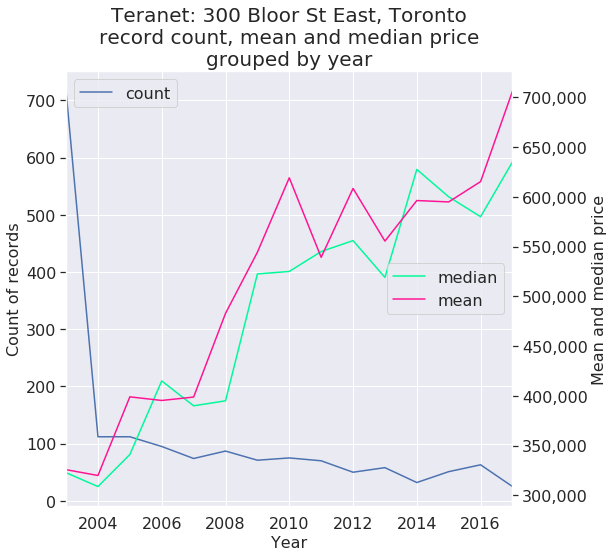

In [77]:
col = 'year'
ax = s.groupby(col)['consideration_amt'].count().plot(figsize=(8, 8), label='count')
# plt.xticks(rotation=45, fontsize=16)
ax2 = ax.twinx()
s.groupby(col)['consideration_amt'].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby(col)['consideration_amt'].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: 300 Bloor St East, Toronto\nrecord count, mean and median price'
              '\ngrouped by year', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()

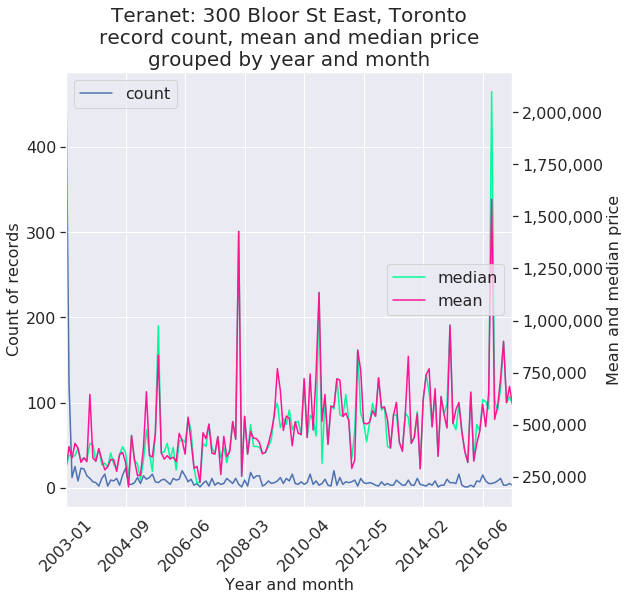

In [78]:
col = 'year_month'
ax = s.groupby(col)['consideration_amt'].count().plot(figsize=(8, 8), label='count')
plt.xticks(rotation=45, fontsize=16)
ax2 = ax.twinx()
s.groupby(col)['consideration_amt'].median().plot(ax=ax2, color='mediumspringgreen', label='median')
s.groupby(col)['consideration_amt'].mean().plot(ax=ax2, color='deeppink', label='mean')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(False)
ax.set_ylabel('Count of records', fontsize=16)
ax.set_xlabel('Year and month', fontsize=16)
ax2.set_ylabel('Mean and median price', fontsize=16)
ax2.set_title('Teranet: 300 Bloor St East, Toronto\nrecord count, mean and median price'
              '\ngrouped by year and month', fontsize=20)
ax.legend(loc='upper left', fontsize=16)
ax2.legend(loc='center right', fontsize=16)
plt.show()